In [1]:
#importing libraries for the purpose of forecasting
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from matplotlib import rcParams
rcParams['figure.figsize'] = 10, 6
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
from datetime import datetime
import pandas_datareader as web
from pandas.plotting import lag_plot




In [2]:
#importing libraries for the purpose of sentiment analysis of news headlines
import datetime as dt
from wordcloud import WordCloud, STOPWORDS
from nltk.stem import SnowballStemmer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from GoogleNews import GoogleNews
from newspaper import Article
from newspaper import Config
import nltk

In [3]:
startdate = '2019-10-14'
today = datetime.today().strftime('%Y-%m-%d')

In [4]:
def getMyPortfolio(stocks = "^NSEBANK" ,start = startdate , end = today):
    data = web.DataReader(stocks , data_source='yahoo' , start = start ,end= end )
    return data

In [5]:
df = getMyPortfolio()
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-10-14,28553.400391,28043.250000,28238.500000,28181.949219,0.0,28181.949219
2019-10-15,28694.849609,28186.250000,28257.849609,28555.099609,0.0,28555.099609
2019-10-16,28759.349609,28305.400391,28689.449219,28538.800781,0.0,28538.800781
2019-10-17,29049.050781,28487.949219,28596.349609,28989.449219,0.0,28989.449219
2019-10-18,29249.500000,28864.099609,28954.800781,29120.250000,0.0,29120.250000
...,...,...,...,...,...,...
2021-04-09,32972.148438,32329.949219,32636.900391,32448.050781,0.0,32448.050781
2021-04-12,31698.050781,30520.300781,31637.900391,30792.000000,0.0,30792.000000
2021-04-13,31885.449219,30722.849609,30901.800781,31771.599609,0.0,31771.599609


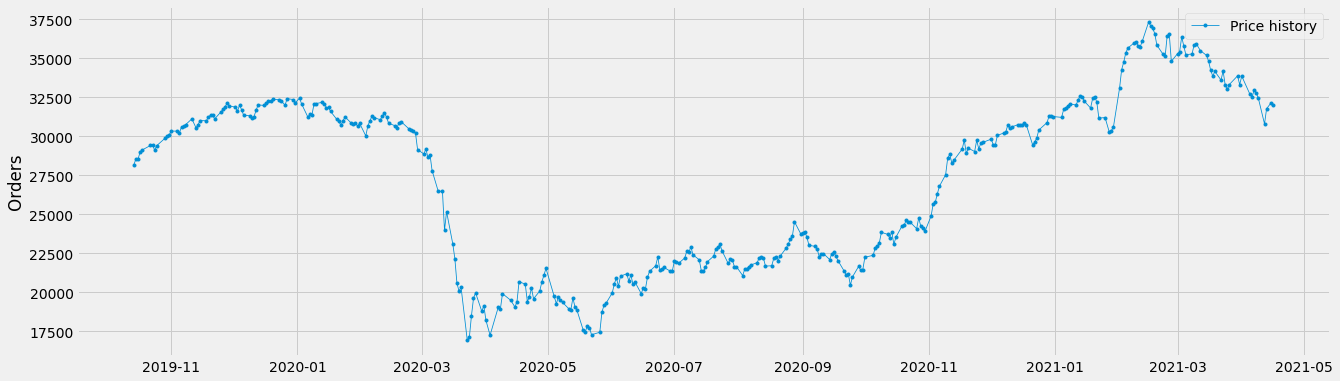

In [6]:
y = df['Close']
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(y,marker='.', linestyle='-', linewidth=0.8, label='Price history')
ax.set_ylabel('Orders')
ax.legend()

In [7]:
def seasonal_decompose (y):
    decomposition = sm.tsa.seasonal_decompose(y, model='additive',extrapolate_trend='freq',period=1)
    fig = decomposition.plot()
    fig.set_size_inches(14,7)
    plt.show()

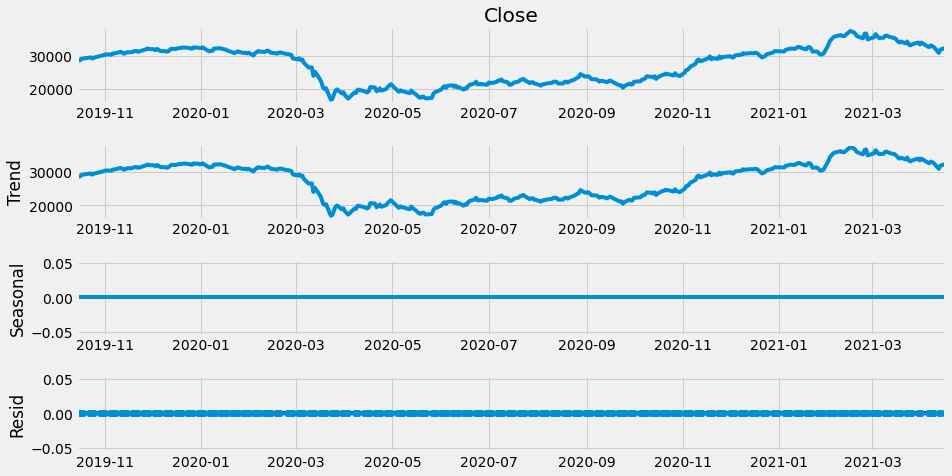

In [8]:
seasonal_decompose(y)

In [9]:
y

Date
2019-10-14    28181.949219
2019-10-15    28555.099609
2019-10-16    28538.800781
2019-10-17    28989.449219
2019-10-18    29120.250000
                  ...     
2021-04-09    32448.050781
2021-04-12    30792.000000
2021-04-13    31771.599609
2021-04-15    32112.849609
2021-04-16    31977.449219
Name: Close, Length: 372, dtype: float64

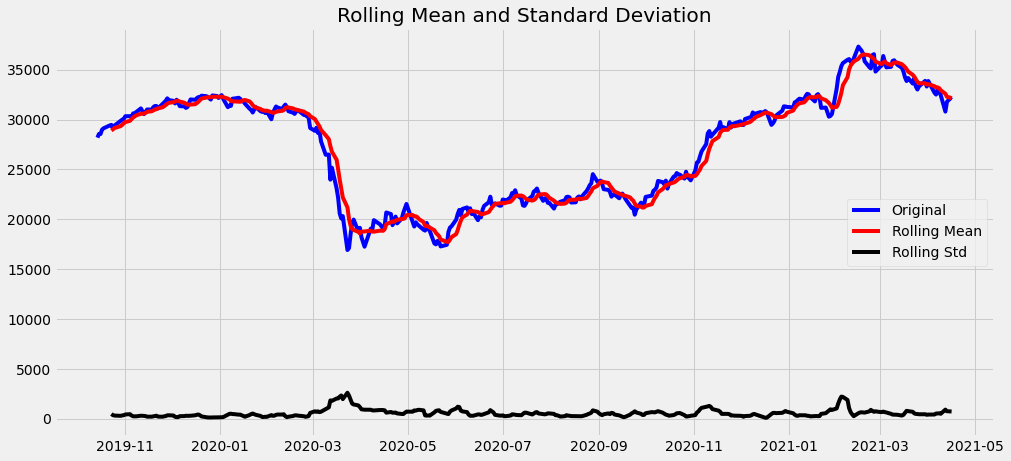

In [10]:
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(7).mean()
    rolstd = timeseries.rolling(7).std()
    #Plot rolling statistics:
    plt.figure(figsize=(15,7))
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
test_stationarity(y)

In [11]:
def ADF_test(timeseries, dataDesc):
    print(' > Is the {} stationary ?'.format(dataDesc))
    dftest = adfuller(timeseries.dropna(), autolag='AIC')
    print('Test statistic = {:.3f}'.format(dftest[0]))
    print('P-value = {:.3f}'.format(dftest[1]))
    print('Critical values :')
    for k, v in dftest[4].items():
        print('\t{}: {} - The data is {} stationary with {}% confidence'.format(k, v, 'not' if v<dftest[0] else '', 100-int(k[:-1])))

In [12]:
ADF_test(y,'data')

 > Is the data stationary ?
Test statistic = -1.082
P-value = 0.722
Critical values :
	1%: -3.4483935212959844 - The data is not stationary with 99% confidence
	5%: -2.8694912343676497 - The data is not stationary with 95% confidence
	10%: -2.571005879151811 - The data is not stationary with 90% confidence


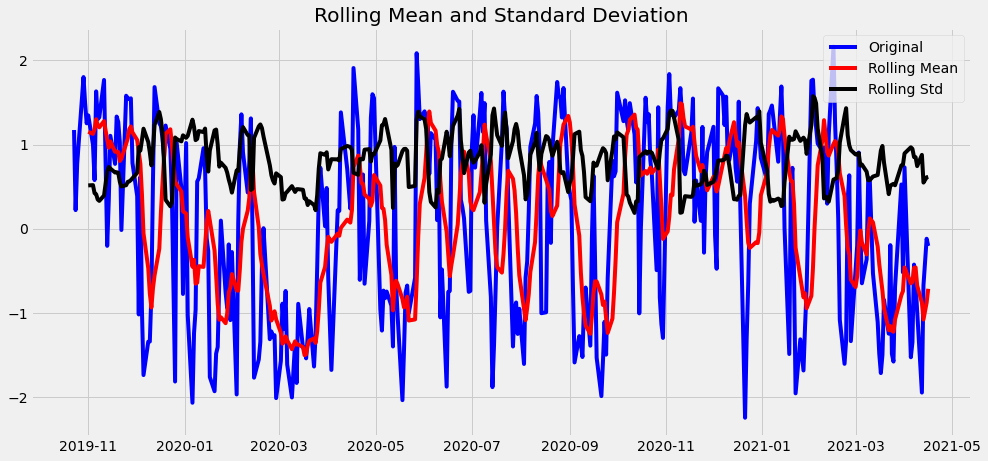

 > Is the de-trended data stationary ?
Test statistic = -8.205
P-value = 0.000
Critical values :
	1%: -3.4483935212959844 - The data is  stationary with 99% confidence
	5%: -2.8694912343676497 - The data is  stationary with 95% confidence
	10%: -2.571005879151811 - The data is  stationary with 90% confidence


In [13]:
y_detrend =  (y - y.rolling(window=7).mean())/y.rolling(window=7).std()

test_stationarity(y_detrend)
ADF_test(y_detrend,'de-trended data')

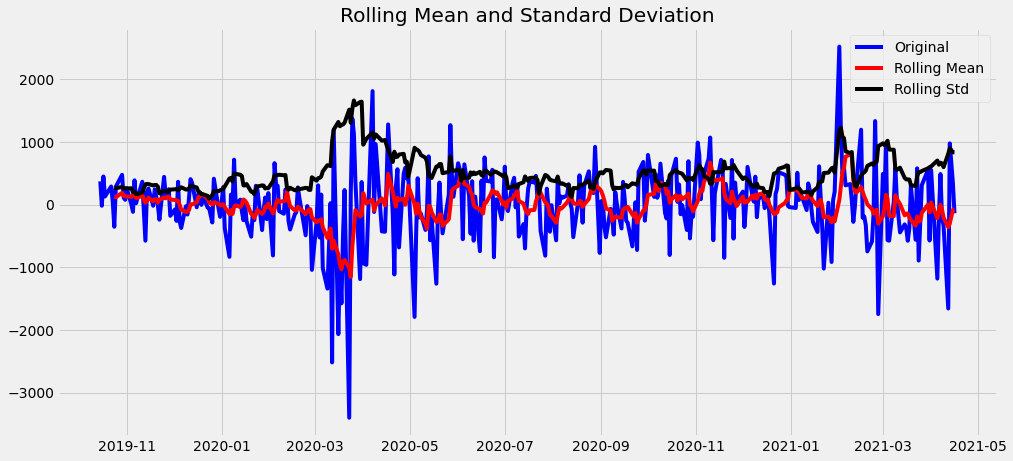

 > Is the 1st diffrence data stationary ?
Test statistic = -7.085
P-value = 0.000
Critical values :
	1%: -3.4483935212959844 - The data is  stationary with 99% confidence
	5%: -2.8694912343676497 - The data is  stationary with 95% confidence
	10%: -2.571005879151811 - The data is  stationary with 90% confidence


In [14]:
y_diff_1 = y.diff()
y_diff_1.dropna(how='any',inplace=True)

test_stationarity(y_diff_1)
ADF_test(y_diff_1, '1st diffrence data')

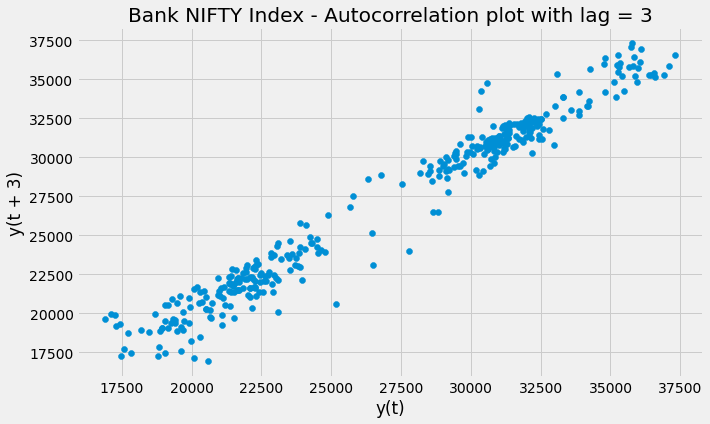

In [15]:
plt.figure()
lag_plot(df['Close'], lag=3)
plt.title('Bank NIFTY Index - Autocorrelation plot with lag = 3')
plt.show()

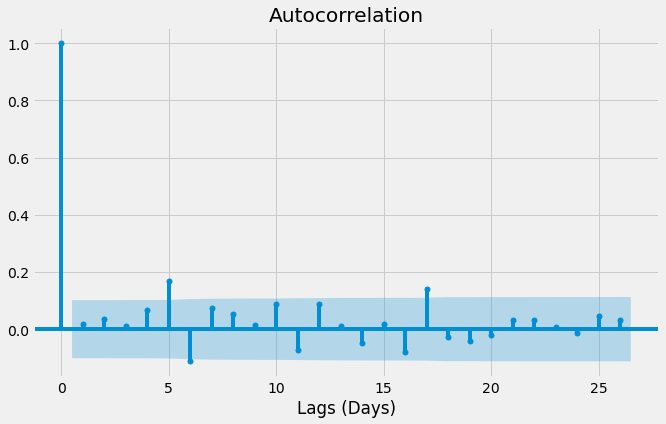

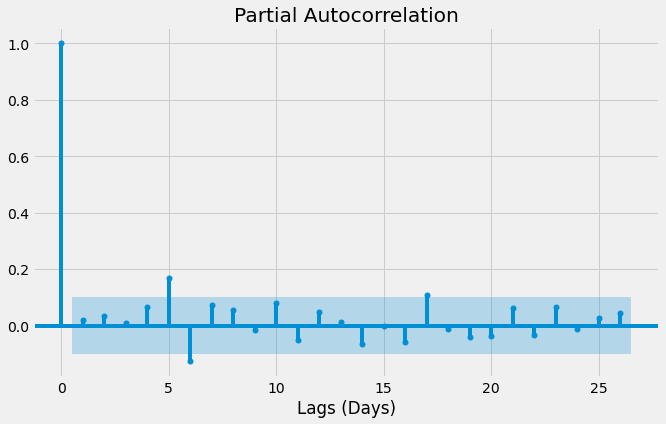

In [16]:
plot_acf(y_diff_1)
plt.xlabel('Lags (Days)')
plt.show()
plot_pacf(y_diff_1)
plt.xlabel('Lags (Days)')
plt.show()

In [17]:
y_detrend.dropna(how='any',inplace=True)
y_detrend

Date
2019-10-23    1.173216
2019-10-24    0.222593
2019-10-25    0.773045
2019-10-29    1.801683
2019-10-30    1.496172
                ...   
2021-04-09   -0.977738
2021-04-12   -1.943159
2021-04-13   -0.669865
2021-04-15   -0.117644
2021-04-16   -0.201887
Name: Close, Length: 366, dtype: float64

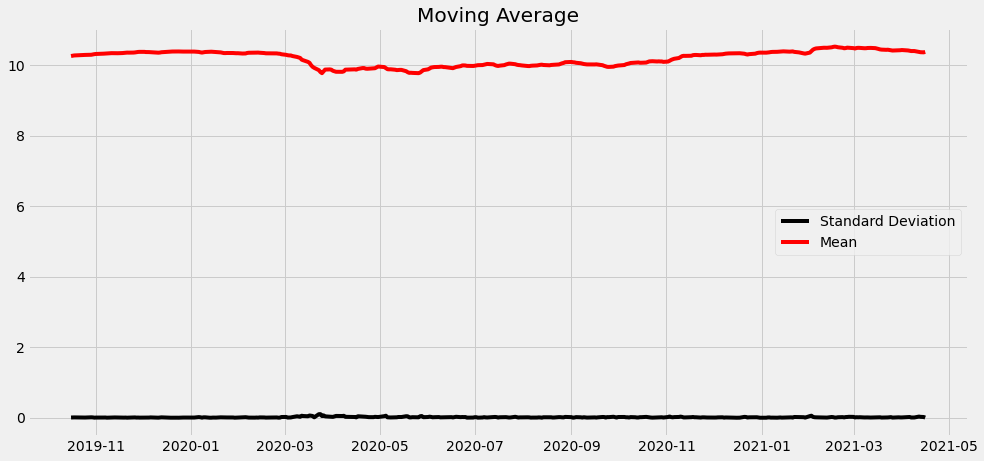

In [18]:
rcParams['figure.figsize'] = 15, 7
df_log = np.log(y)
moving_avg = df_log.rolling(3).mean()
std_dev = df_log.rolling(3).std()
ax.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

In [19]:
df.reset_index(inplace=True)
df['Date'] = pd.to_datetime(df.Date,format='%Y-%m-%d')
df.index = df['Date']

#sorting
data = df.sort_index(ascending=True, axis=0)

#creating a separate dataset
new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Close'])

for i in range(0,len(data)):
    new_data['Date'][i] = data['Date'][i]
    new_data['Close'][i] = data['Close'][i]

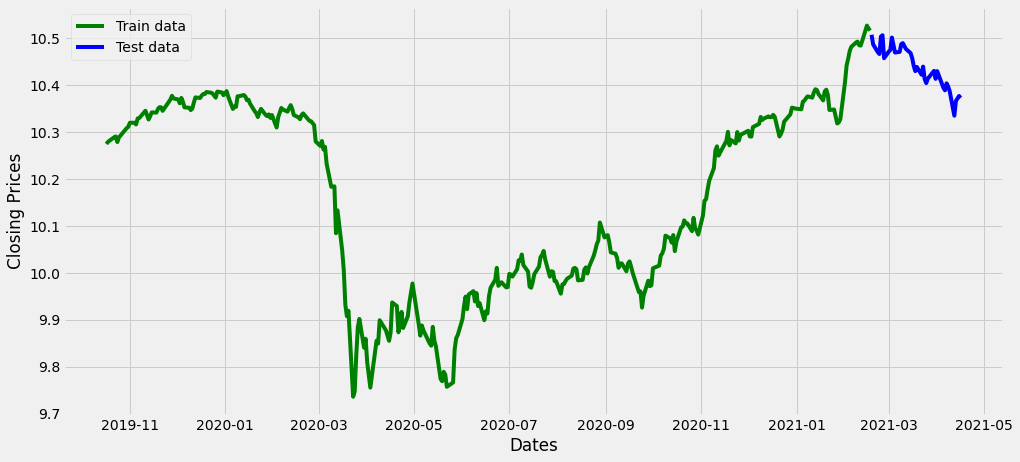

In [20]:
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(15,7))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(train_data, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend();

In [21]:
smodel = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find             optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(smodel.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1493.993, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1492.101, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1492.099, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1495.710, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1490.100, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.092 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  331
Model:               SARIMAX(0, 1, 0)   Log Likelihood                 748.855
Date:                Sun, 18 Apr 2021   AIC                          -1495.710
Time:                        12:42:34   BIC                          -1491.911
Sample:                             0   HQIC                         -1494.195
                                - 331                                  

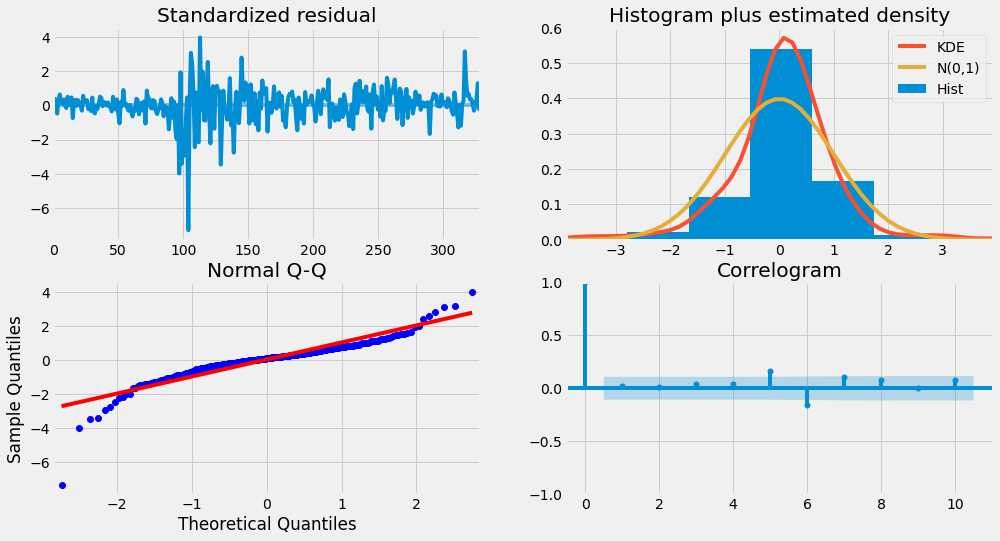

In [22]:
smodel.plot_diagnostics(figsize=(15,8))
plt.show()

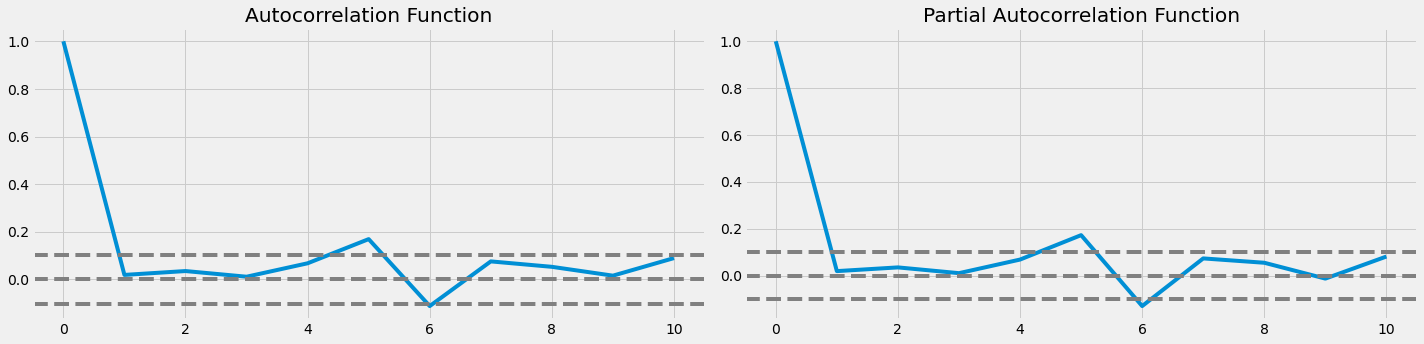

In [23]:
lag_acf = acf(y_diff_1, nlags=10)
lag_pacf = pacf(y_diff_1, nlags=10, method='ols')
plt.figure(figsize=(20,5))
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(y_diff_1)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(y_diff_1)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')
#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(y_diff_1)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(y_diff_1)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

In [24]:
model = ARIMA(train_data, order=(0,1,0))  
fitted1 = model.fit(disp=-1)
print(fitted1.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  330
Model:                 ARIMA(0, 1, 0)   Log Likelihood                 748.996
Method:                           css   S.D. of innovations              0.025
Date:                Sun, 18 Apr 2021   AIC                          -1493.993
Time:                        12:42:34   BIC                          -1486.395
Sample:                             1   HQIC                         -1490.962
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0007      0.001      0.532      0.595      -0.002       0.003


/Users/utkarshsinghal06/miniforge3/envs/tf24/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/utkarshsinghal06/miniforge3/envs/tf24/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


/Users/utkarshsinghal06/miniforge3/envs/tf24/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/utkarshsinghal06/miniforge3/envs/tf24/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


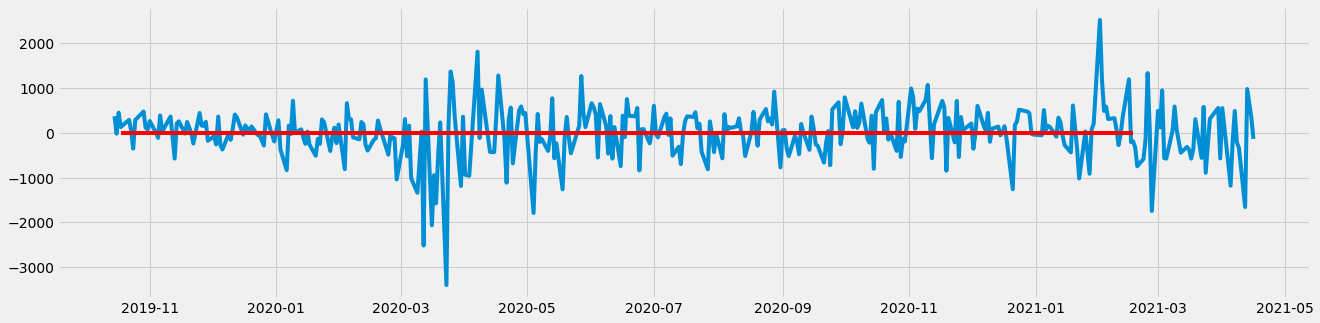

In [25]:
model = ARIMA(train_data, order=(0,1,0))  
results_AR = model.fit()  
plt.figure(figsize=(20,5))
plt.plot(y_diff_1)
plt.plot(results_AR.fittedvalues, color='red')

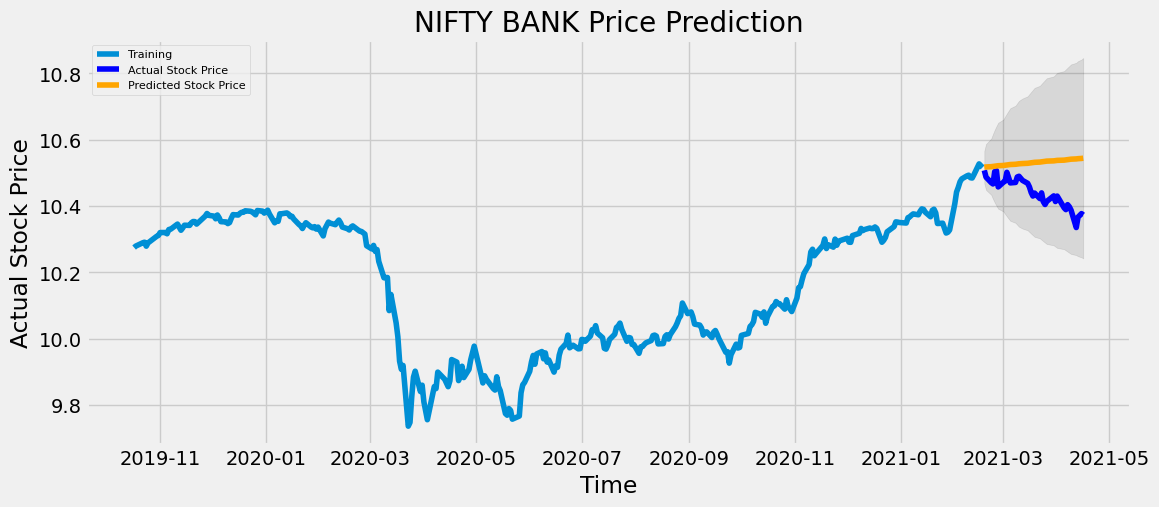

In [26]:

# Forecast
fc, se, conf = fitted1.forecast(test_data.shape[0], alpha=0.05)  # 95% confidence
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_data, label='Training')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('NIFTY BANK Price Prediction')
plt.xlabel('Time')
plt.ylabel('Actual Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()



In [27]:
mse = mean_squared_error(test_data, fc)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data, fc)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data, fc))
print('RMSE: '+str(rmse))

MSE: 0.010689723570509263
MAE: 0.08965245322265858
RMSE: 0.10339111939866626


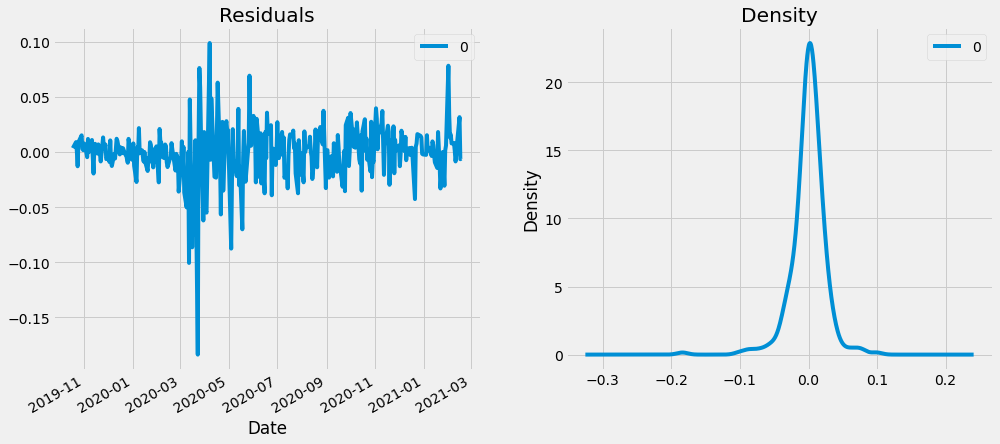

In [28]:
# Plotting residual errors
residuals = pd.DataFrame(fitted1.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

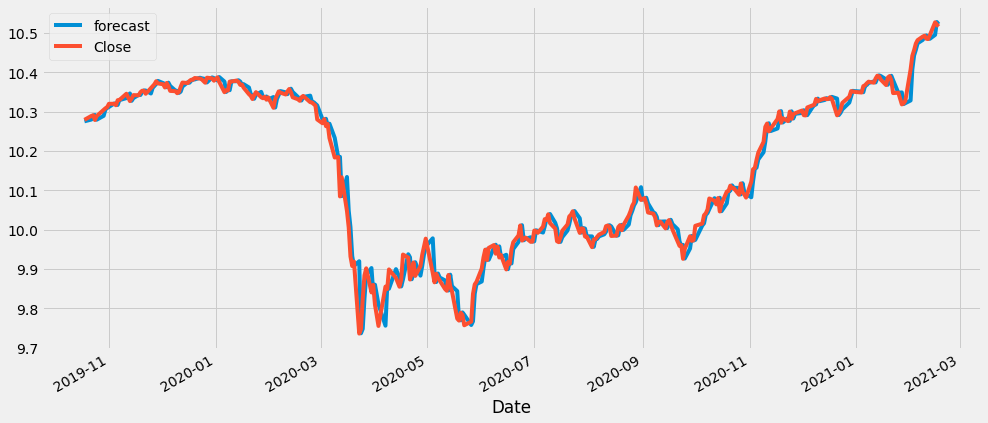

In [29]:
fitted1.plot_predict(dynamic=False)
plt.show()

In [30]:
# Sentiment Analysis

In [31]:
now = dt.date.today()
now = now.strftime('%m-%d-%Y')
yesterday = dt.date.today() - dt.timedelta(days = 2)
yesterday = yesterday.strftime('%m-%d-%Y')

nltk.download('punkt')
user_agent = 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36'
config = Config()
config.browser_user_agent = user_agent



[nltk_data] Downloading package punkt to
[nltk_data]     /Users/utkarshsinghal06/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Please provide the name of the Company or a Ticker: Bank Nifty
           Date                  Media  \
0     1 day ago  The Financial Express   
1     1 day ago               CNBCTV18   
2     1 day ago               NDTV.com   
3  20 hours ago                   Mint   
4  19 hours ago           Zee Business   
5     1 day ago           Moneycontrol   
6  20 hours ago     The Economic Times   
7   4 hours ago           Moneycontrol   
8     1 day ago               CNBCTV18   
9     1 day ago           Moneycontrol   

                                               Title  \
0  Market HIGHLIGHTS: Sensex gives up 49k, ends f...   
1  Closing Bell: Sensex, Nifty end flat as IT gai...   
2  Sensex, Nifty Gain For Third Session In A Row ...   
3  HDFC Bank share price may show weakness, say e...   
4  Stock Market Outlook: Anil Singhvi reveals Nif...   
5  Technical View: Nifty forms Doji pattern; expe...   
6  Pharma stocks momentum is not going to abate a...   
7  Nifty to remain volatil

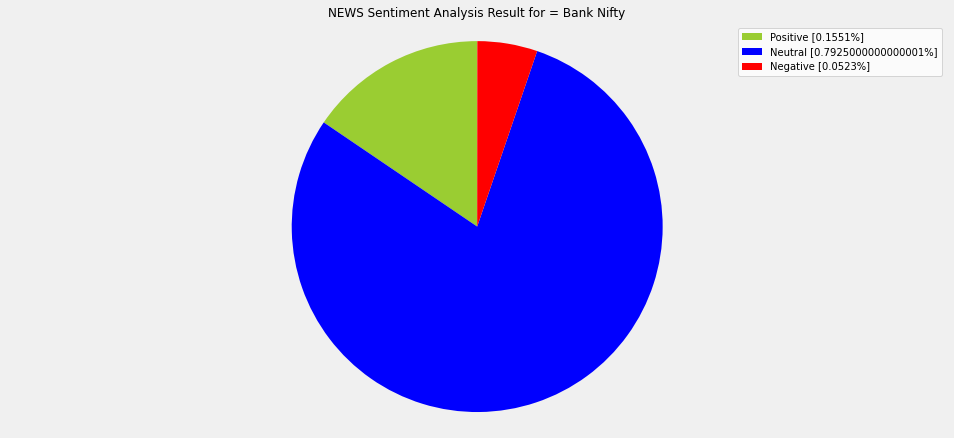

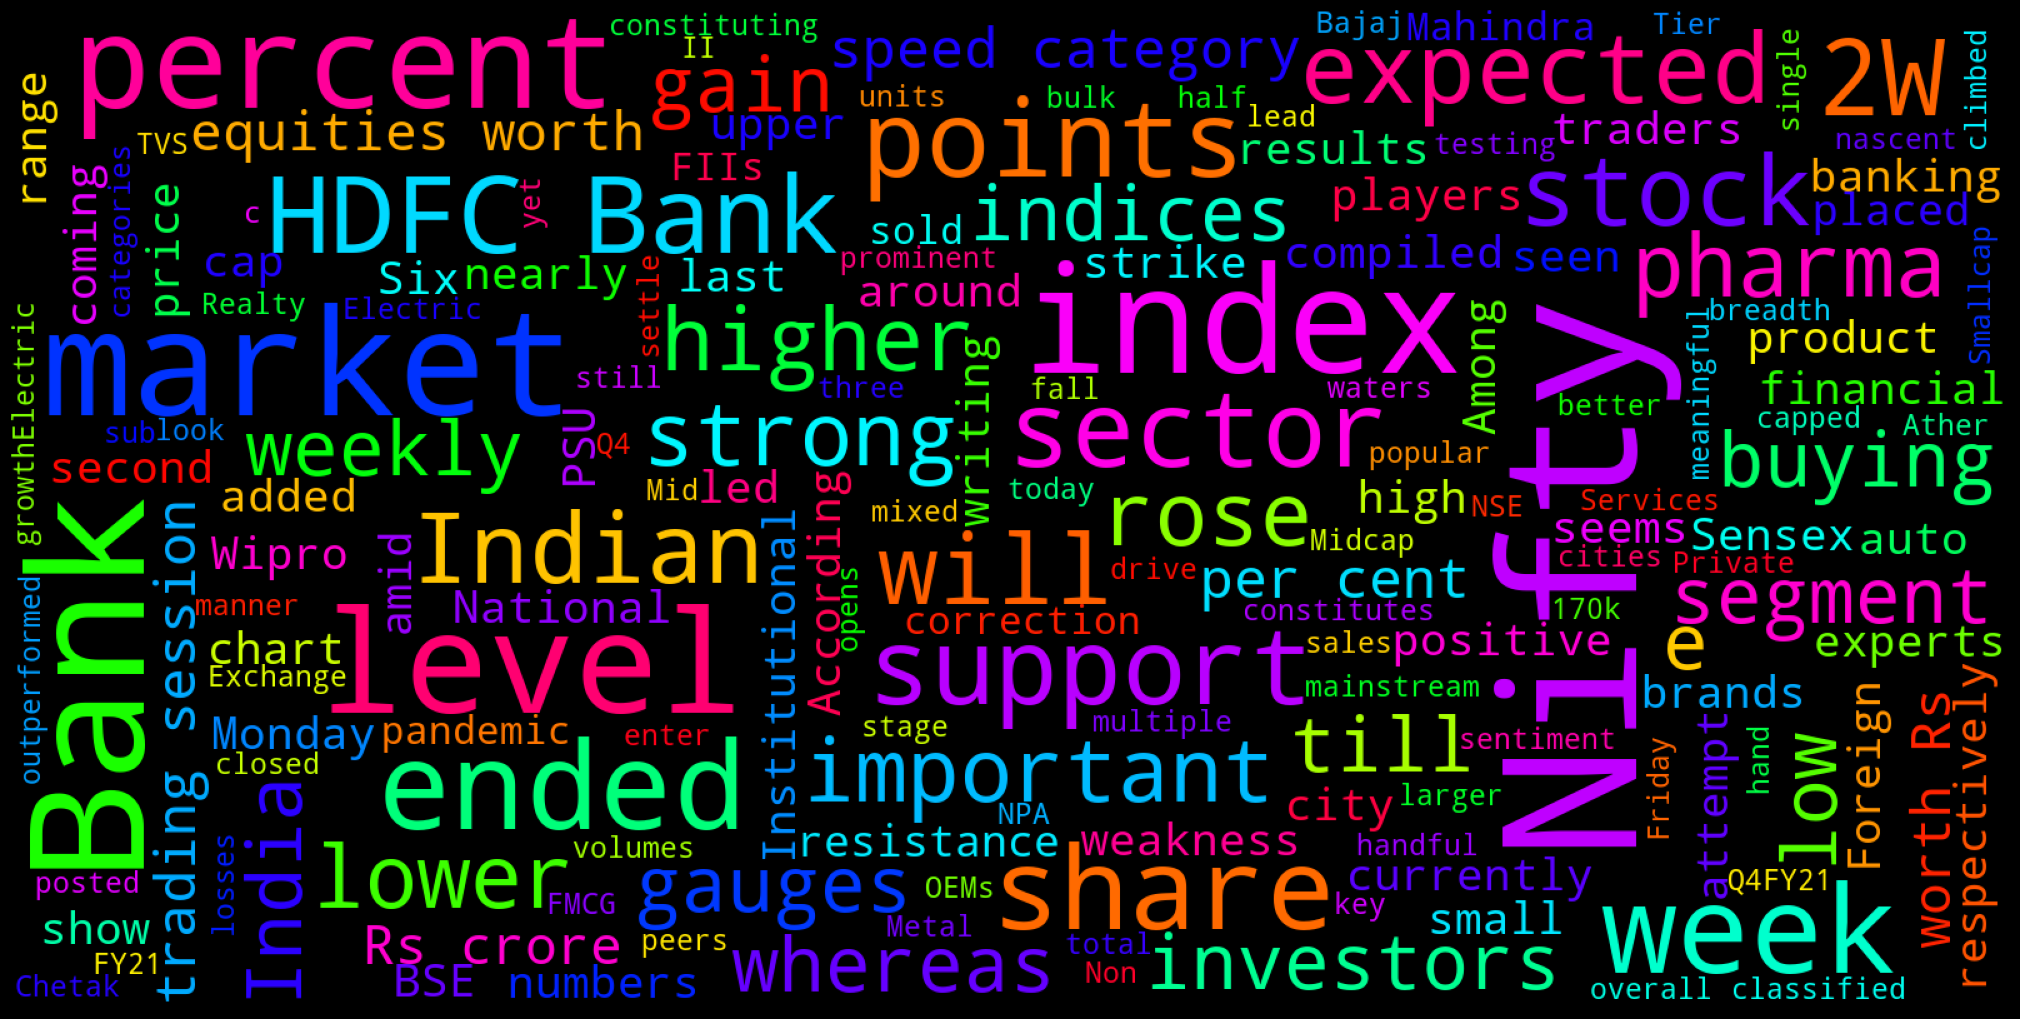

In [32]:
company_name = input("Please provide the name of the Company or a Ticker: ")

googlenews = GoogleNews(start=yesterday,end=now)
googlenews.search(company_name)
result = googlenews.result()
df = pd.DataFrame(result)
try:
    list =[]
    for ind in df.index:
        dict = {}
        article = Article(df['link'][ind],config=config)
        article.download()
        article.parse()
        article.nlp()
        dict['Date']=df['date'][ind]
        dict['Media']=df['media'][ind]
        dict['Title']=article.title
        dict['Article']=article.text
        dict['Summary']=article.summary
        dict['Key_words']=article.keywords
        list.append(dict)
    news_df=pd.DataFrame(list)
    print(news_df)

    analyzer = SentimentIntensityAnalyzer()

    news_df['compound'] = [analyzer.polarity_scores(x)['compound'] for x in news_df['Summary']]
    news_df['neg'] = [analyzer.polarity_scores(x)['neg'] for x in news_df['Summary']]
    news_df['neu'] = [analyzer.polarity_scores(x)['neu'] for x in news_df['Summary']]
    news_df['pos'] = [analyzer.polarity_scores(x)['pos'] for x in news_df['Summary']]

    # Taking averages of sentiment score columns
    N_avg_compound = np.average(news_df['compound'])
    N_avg_neg = np.average(news_df['neg']) 
    N_avg_neu = np.average(news_df['neu'])
    N_avg_pos = np.average(news_df['pos'])

    print("Positive Sentiment:", '%.2f' % N_avg_pos, end='\n*')
    print("Neutral Sentiment:", '%.2f' % N_avg_neu, end='\n*')
    print("Negative Sentiment:", '%.2f' % N_avg_neg, end='\n*')
    print("Compound Sentiment:", '%.2f' % N_avg_compound, end='\n')

    #Creating PieCart
    labels = ['Positive ['+str(N_avg_pos)+'%]' , 'Neutral ['+str(N_avg_neu)+'%]','Negative ['+str(N_avg_neg)+'%]']
    sizes = [N_avg_pos, N_avg_neu, N_avg_neg]
    colors = ['yellowgreen', 'blue','red']
    fig, ax = plt.subplots()
    patches, texts = ax.pie(sizes,colors=colors, startangle=90)
    plt.style.use('default')
    ax.legend(labels)
    ax.set_title("NEWS Sentiment Analysis Result for = "+company_name+"" )
    ax.axis('equal')
    print(fig)

    # word cloud visualization
    def news_cloud(text):
        stopwords = set(STOPWORDS)
        N_allWords = ' '.join([nws for nws in text])
        newsCloud = WordCloud(background_color='black',width = 1600, height = 800,stopwords = stopwords,min_font_size = 20,max_font_size=150,colormap='hsv').generate(N_allWords)
        fig, ax = plt.subplots(figsize=(20,10), facecolor='k')
        plt.imshow(newsCloud)
        ax.axis("off")
        fig.tight_layout(pad=0)
        print(fig)

    print('Wordcloud for ' + company_name)
    news_cloud(news_df['Summary'].values)

except Exception as e:
    print("exception occurred:" + str(e))


